In [41]:
import os
import sys

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data

sys.path.append("..")

from src.gnn import MixHopNet
from src.load_data import load_data
from src.sheaf import CSNN
from src.utils import accuracy, f1_macro

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
if not os.path.exists("../images"):
    os.makedirs("../images")

## Load dataset


In [43]:
DATASET_NAME = "wisconsin"  # ['texas', 'cornell', 'wisconsin']
SPLIT = [0.7, 0.2, 0.1]  # Train, Val, Test split ratios

In [44]:
torch.manual_seed(42)
data: Data
data, train_mask, val_mask, test_mask, num_classes, class_weights = load_data(
    DATASET_NAME, SPLIT
)

Wisconsin | num_nodes=251 | num_classes=5
Train=174, val=49, test=28
class_counts: [7.0, 49.0, 82.0, 22.0, 14.0]
class_weights: [2.4433090686798096, 0.34904420375823975, 0.20857517421245575, 0.7774165272712708, 1.2216546535491943]


c:\Users\Gomi\OneDrive - Universidad Pontificia Comillas\5ºIMAT\Geometria de la Informacion\Sheaf-NN\.venv\lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

## Sheaf-NN


In [45]:
torch.manual_seed(42)
# Modelo CSNN
model = CSNN(
    in_dim=data.x.size(-1),
    hidden_dim=64,  # prueba también 64
    out_dim=num_classes,
    num_nodes=data.num_nodes,
    edge_index=data.edge_index,
    num_layers=2,  # el paper suele usar bastantes capas
    dropout=0.6,
).to(device)

### Training


In [46]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4,
)
criterion = nn.CrossEntropyLoss(weight=class_weights)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=100, min_lr=1e-5
)

In [47]:
# Históricos para plotting
train_acc_hist, val_acc_hist, test_acc_hist = [], [], []
train_f1_hist, val_f1_hist, test_f1_hist = [], [], []

# Entrenamiento con early stopping
best_val_acc = 0.0
best_state = None
max_epochs = 500

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        out = model(data.x)

        # Accuracies
        train_acc = accuracy(out[train_mask], data.y[train_mask])
        val_acc = accuracy(out[val_mask], data.y[val_mask])
        test_acc = accuracy(out[test_mask], data.y[test_mask])

        # F1 macro
        train_f1 = f1_macro(
            out[train_mask], data.y[train_mask], num_classes=num_classes
        )
        val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
        test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

    # Guardar históricos
    train_acc_hist.append(float(train_acc))
    val_acc_hist.append(float(val_acc))
    test_acc_hist.append(float(test_acc))

    train_f1_hist.append(train_f1)
    val_f1_hist.append(val_f1)
    test_f1_hist.append(test_f1)

    # Early stopping basado en validación
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 50 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:04d} | "
            f"loss {loss.item():.4f} | "
            f"train acc {train_acc:.4f} | "
            f"val acc {val_acc:.4f} | "
            f"test acc {test_acc:.4f} | "
            f"train f1 {train_f1:.4f} | "
            f"val f1 {val_f1:.4f} | "
            f"test f1 {test_f1:.4f}"
        )

    lr_scheduler.step(val_acc)

# Cargar mejor modelo
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

model.eval()
with torch.no_grad():
    out = model(data.x)
    final_train_acc = accuracy(out[train_mask], data.y[train_mask])
    final_val_acc = accuracy(out[val_mask], data.y[val_mask])
    final_test_acc = accuracy(out[test_mask], data.y[test_mask])

    final_train_f1 = f1_macro(
        out[train_mask], data.y[train_mask], num_classes=num_classes
    )
    final_val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
    final_test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

print(
    f"Final | "
    f"train acc {final_train_acc:.4f} | val acc {final_val_acc:.4f} | test acc {final_test_acc:.4f} | "
    f"train f1 {final_train_f1:.4f} | val f1 {final_val_f1:.4f} | test f1 {final_test_f1:.4f}"
)


Epoch 0001 | loss 1.6052 | train acc 0.1264 | val acc 0.1224 | test acc 0.1429 | train f1 0.0449 | val f1 0.0436 | test f1 0.0500
Epoch 0050 | loss 0.7501 | train acc 0.6782 | val acc 0.5714 | test acc 0.5000 | train f1 0.6244 | val f1 0.4777 | test f1 0.4398
Epoch 0100 | loss 0.2348 | train acc 0.9943 | val acc 0.7959 | test acc 0.8571 | train f1 0.9854 | val f1 0.5933 | test f1 0.7059
Epoch 0150 | loss 0.1264 | train acc 1.0000 | val acc 0.8367 | test acc 0.8571 | train f1 1.0000 | val f1 0.5893 | test f1 0.6744
Epoch 0200 | loss 0.0510 | train acc 1.0000 | val acc 0.8980 | test acc 0.7857 | train f1 1.0000 | val f1 0.6970 | test f1 0.5996
Epoch 0250 | loss 0.0252 | train acc 1.0000 | val acc 0.8776 | test acc 0.8571 | train f1 1.0000 | val f1 0.6841 | test f1 0.7192
Epoch 0300 | loss 0.0189 | train acc 1.0000 | val acc 0.8776 | test acc 0.8214 | train f1 1.0000 | val f1 0.6699 | test f1 0.6324
Epoch 0350 | loss 0.0371 | train acc 1.0000 | val acc 0.8776 | test acc 0.8571 | train f1 

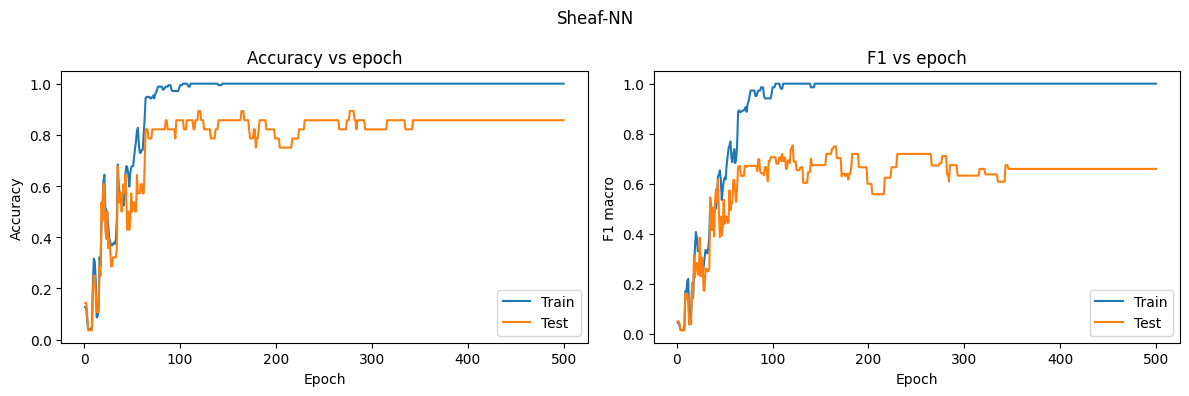

In [48]:
# Gráficas: accuracy y F1 vs epochs para train y test
epochs = range(1, max_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Sheaf-NN")

# Accuracy
axes[0].plot(epochs, train_acc_hist, label="Train")
axes[0].plot(epochs, test_acc_hist, label="Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy vs epoch")
axes[0].legend()

# F1 macro
axes[1].plot(epochs, train_f1_hist, label="Train")
axes[1].plot(epochs, test_f1_hist, label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("F1 macro")
axes[1].set_title("F1 vs epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

# Save figure
fig.savefig(f"../images/comparative_sheaf_{DATASET_NAME}.png", dpi=300)

## GNN


In [49]:
model = MixHopNet(
    in_dim=data.x.size(-1),
    hidden_dim=32,
    out_dim=num_classes,
    dropout=0.8,
    powers=(0, 1, 2),
).to(device)

### Training


In [50]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4,
)
criterion = nn.CrossEntropyLoss(weight=class_weights)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=100, min_lr=1e-5
)

In [51]:
# Históricos para plotting
train_acc_hist, val_acc_hist, test_acc_hist = [], [], []
train_f1_hist, val_f1_hist, test_f1_hist = [], [], []

# Entrenamiento con early stopping
best_val_acc = 0.0
best_state = None
max_epochs = 500

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)

        # Accuracies
        train_acc = accuracy(out[train_mask], data.y[train_mask])
        val_acc = accuracy(out[val_mask], data.y[val_mask])
        test_acc = accuracy(out[test_mask], data.y[test_mask])

        # F1 macro
        train_f1 = f1_macro(
            out[train_mask], data.y[train_mask], num_classes=num_classes
        )
        val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
        test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

    # Guardar históricos
    train_acc_hist.append(float(train_acc))
    val_acc_hist.append(float(val_acc))
    test_acc_hist.append(float(test_acc))

    train_f1_hist.append(train_f1)
    val_f1_hist.append(val_f1)
    test_f1_hist.append(test_f1)

    # Early stopping basado en validación
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 50 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:04d} | "
            f"loss {loss.item():.4f} | "
            f"train acc {train_acc:.4f} | "
            f"val acc {val_acc:.4f} | "
            f"test acc {test_acc:.4f} | "
            f"train f1 {train_f1:.4f} | "
            f"val f1 {val_f1:.4f} | "
            f"test f1 {test_f1:.4f}"
        )

    lr_scheduler.step(val_acc)

# Cargar mejor modelo
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    final_train_acc = accuracy(out[train_mask], data.y[train_mask])
    final_val_acc = accuracy(out[val_mask], data.y[val_mask])
    final_test_acc = accuracy(out[test_mask], data.y[test_mask])

    final_train_f1 = f1_macro(
        out[train_mask], data.y[train_mask], num_classes=num_classes
    )
    final_val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
    final_test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

print(
    f"Final | "
    f"train acc {final_train_acc:.4f} | val acc {final_val_acc:.4f} | test acc {final_test_acc:.4f} | "
    f"train f1 {final_train_f1:.4f} | val f1 {final_val_f1:.4f} | test f1 {final_test_f1:.4f}"
)


Epoch 0001 | loss 1.6110 | train acc 0.1264 | val acc 0.1224 | test acc 0.1429 | train f1 0.0449 | val f1 0.0436 | test f1 0.0500
Epoch 0050 | loss 1.4523 | train acc 0.4655 | val acc 0.4286 | test acc 0.4286 | train f1 0.3524 | val f1 0.3295 | test f1 0.3357
Epoch 0100 | loss 1.1125 | train acc 0.8621 | val acc 0.7755 | test acc 0.8571 | train f1 0.7827 | val f1 0.6242 | test f1 0.7420
Epoch 0150 | loss 0.9485 | train acc 0.9195 | val acc 0.7551 | test acc 0.7857 | train f1 0.8732 | val f1 0.6687 | test f1 0.6882
Epoch 0200 | loss 0.8636 | train acc 0.9138 | val acc 0.7755 | test acc 0.7857 | train f1 0.8626 | val f1 0.6834 | test f1 0.6939
Epoch 0250 | loss 0.7482 | train acc 0.9195 | val acc 0.6939 | test acc 0.7857 | train f1 0.8732 | val f1 0.5074 | test f1 0.6882
Epoch 0300 | loss 0.7900 | train acc 0.9483 | val acc 0.7959 | test acc 0.8571 | train f1 0.9064 | val f1 0.7000 | test f1 0.7814
Epoch 0350 | loss 0.6079 | train acc 0.9425 | val acc 0.7755 | test acc 0.7857 | train f1 

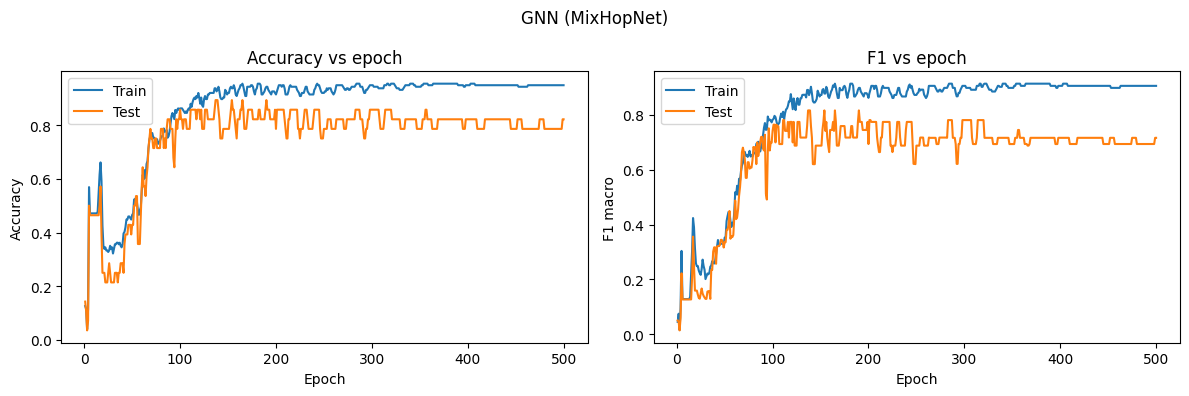

In [52]:
# Gráficas: accuracy y F1 vs epochs para train y test
epochs = range(1, max_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("GNN (MixHopNet)")

# Accuracy
axes[0].plot(epochs, train_acc_hist, label="Train")
axes[0].plot(epochs, test_acc_hist, label="Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy vs epoch")
axes[0].legend()

# F1 macro
axes[1].plot(epochs, train_f1_hist, label="Train")
axes[1].plot(epochs, test_f1_hist, label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("F1 macro")
axes[1].set_title("F1 vs epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

# Save figure
fig.savefig(f"../images/comparative_gnn_{DATASET_NAME}.png", dpi=300)